In [33]:
import os
import glob

import pandas as pd
import numpy as np
import datetime

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr

from netCDF4 import Dataset

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

## font sizes

In [34]:
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

## load data histogram dataframe

In [35]:
df_h = pd.read_csv('/home/meganmason/Documents/projects/thesis/figures/tables/histogram_df.csv',index_col=0)
# binx = np.arange(0,1000,30) #set bin sizes to have as index
df_h
# df_h = df_h.set_index(binx[:-1]) # set index

,2013-04-03,2013-04-29,2013-05-03,2013-05-25,2013-06-01,2013-06-08,2014-03-23,2014-04-07,2014-04-13,2014-04-20,...,2017-03-03,2017-04-01,2017-05-02,2017-06-04,2017-07-09,2017-07-17,2017-07-27,2017-08-16,2018-04-23,2018-05-28
0,5844481,7538277,7397249,5350535,4321763,3448293,6976519,7935374,7113817,5290023,...,2742418,3466294,3908190,5756440,4316647,3270741,1806629,591526,10026444,4790759
30,6958706,7795638,7481735,4875344,3661909,2281796,9816733,9756070,9930370,8295167,...,3536900,4112576,3698029,5372871,3783282,2443430,1129143,315052,12434448,6004986
60,7623299,7862578,7133547,3656792,2600238,1349610,11491083,10927699,11729498,9842336,...,3833847,3949623,3790607,5077256,3237341,1957322,883443,257263,13723677,5984800
90,8176501,7241880,6151670,2671811,1868452,915760,12315762,11923547,12597853,10282417,...,4086621,4071375,4221592,5570346,2791145,1580034,729433,223981,14416119,5048745
120,8422579,5986461,4683397,1883488,1341102,651522,10450463,12210684,11121404,8715334,...,4306804,4358983,4925414,6207368,2316173,1261855,607050,195089,13161254,3517460
150,7785921,4422139,3286975,1303217,957984,467693,6530522,10115076,7428649,6015095,...,4562862,4818230,5824842,6658670,1864732,1005509,507846,168945,10621141,2237773
180,6464805,3034087,2223852,895570,676621,333144,3282311,6651807,4062703,3676507,...,4846774,5433625,6725629,6848335,1464297,810824,425986,147118,7759544,1407180
210,4772982,2025130,1481696,624450,480548,237202,1630077,3694249,2116920,2148712,...,5200628,6222635,7462771,6617722,1153133,663008,360375,127457,5261482,892712
240,3202367,1336072,987154,435067,338977,171609,885640,1981074,1159080,1242125,...,5649175,7087750,7741122,5973451,915694,546838,298200,107442,3330168,577130
270,2056461,893248,666512,305289,240663,124718,514858,1107692,670988,732099,...,6196553,7678964,7547865,5180558,740784,452053,252166,92655,2025223,386452


## plot histograms

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/matplotlib/pyplot

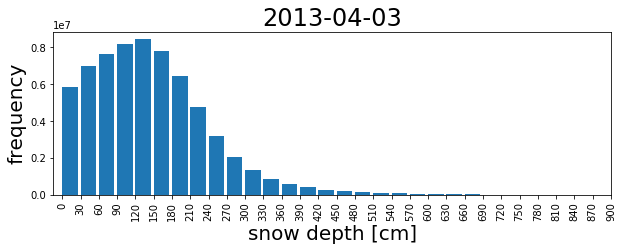

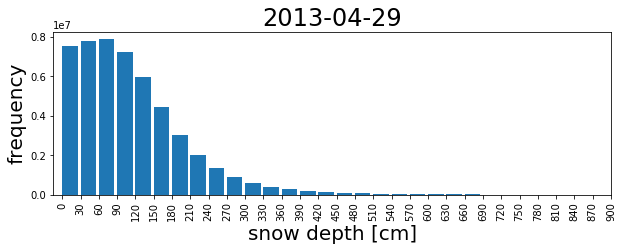

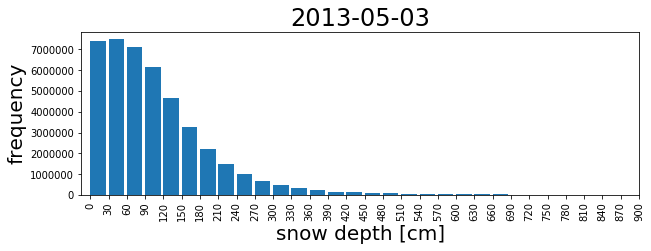

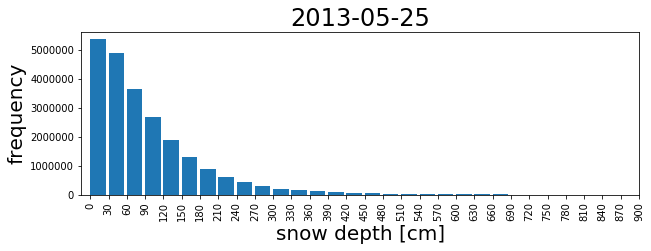

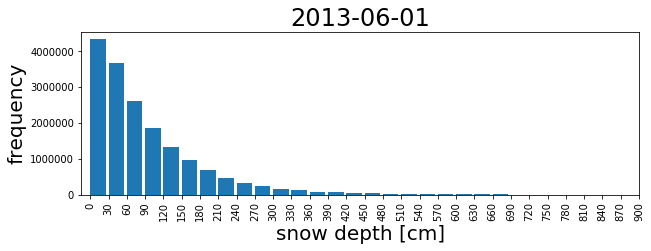

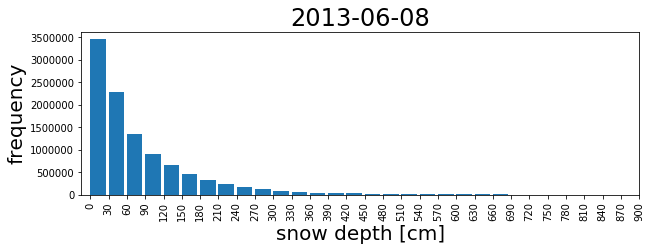

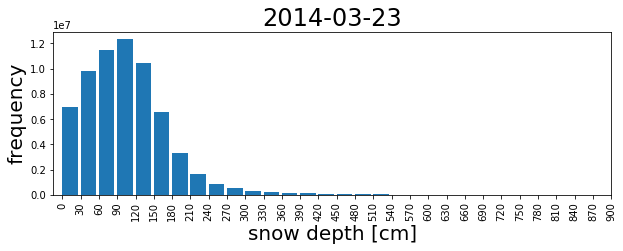

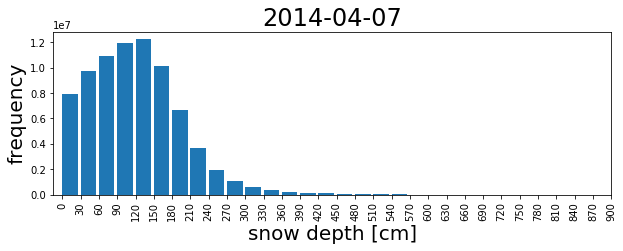

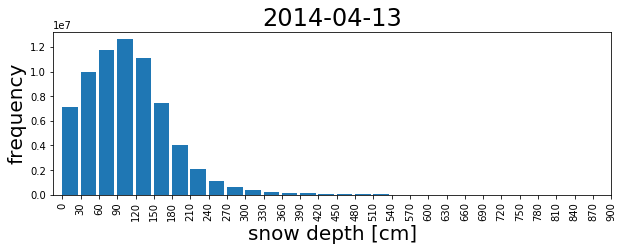

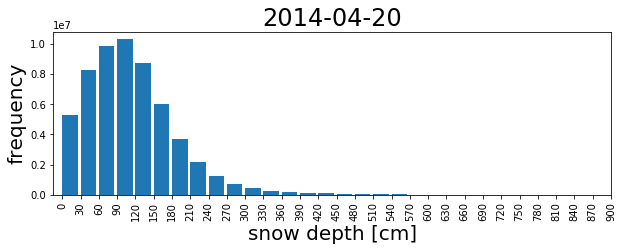

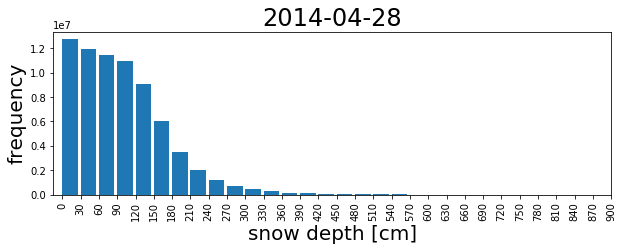

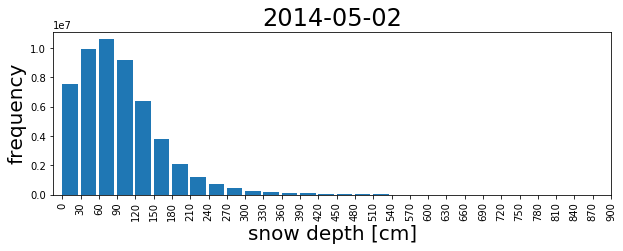

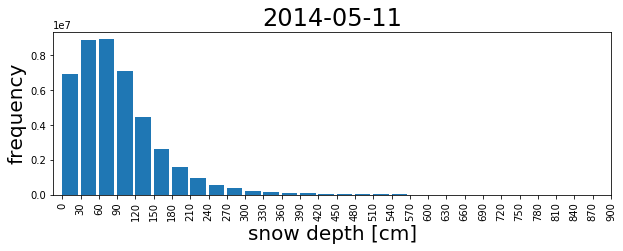

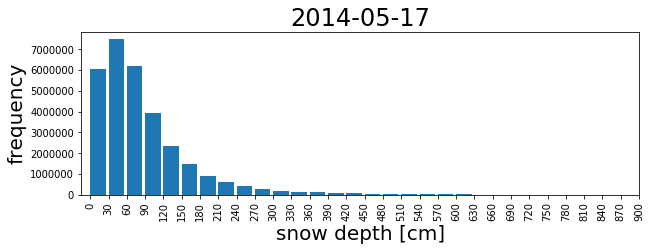

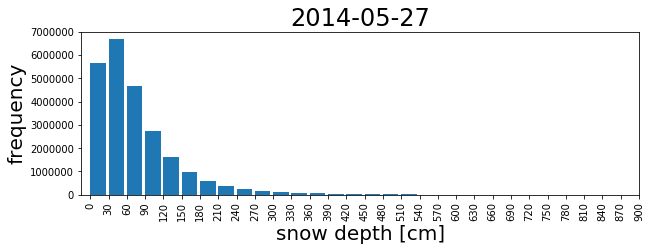

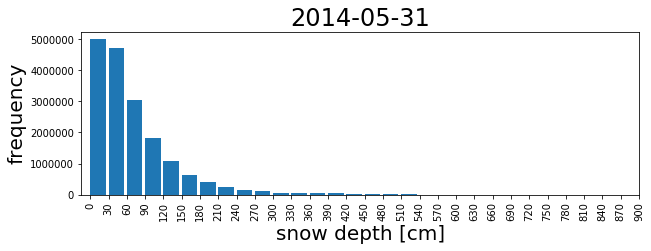

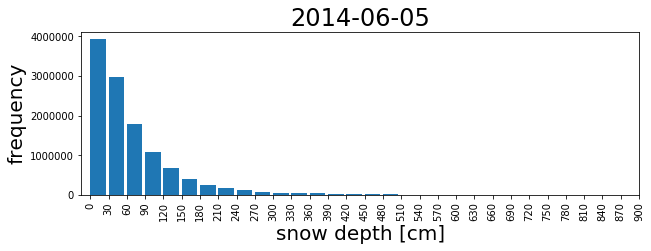

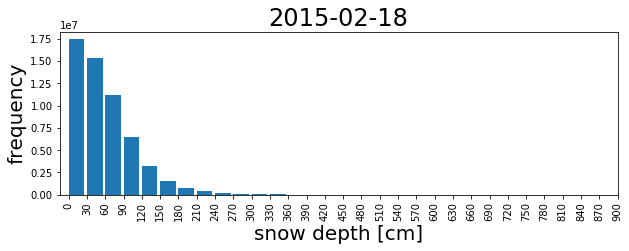

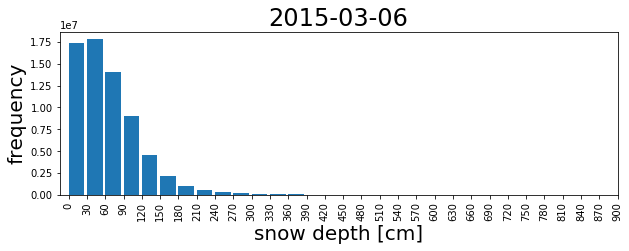

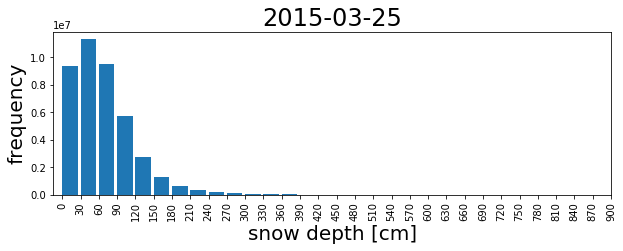

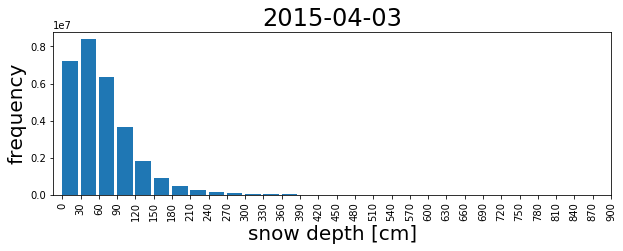

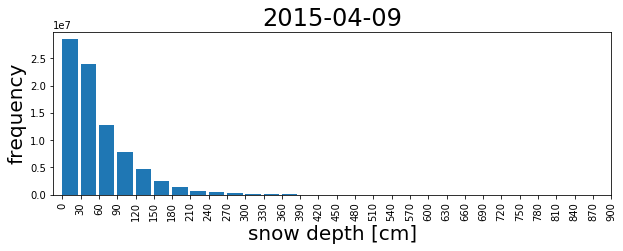

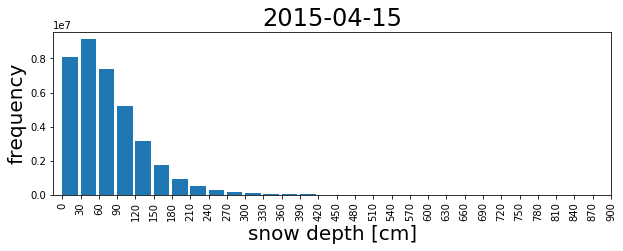

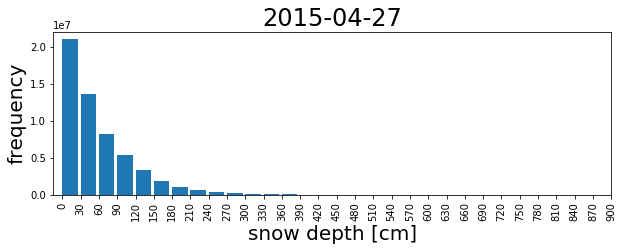

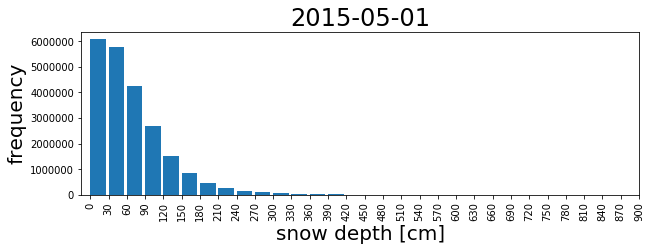

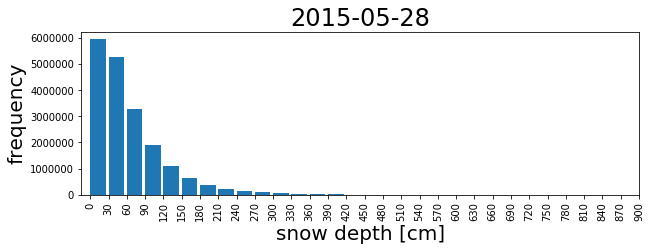

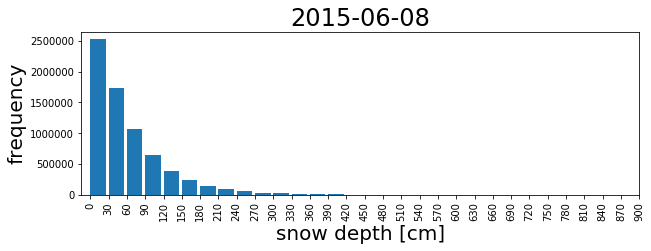

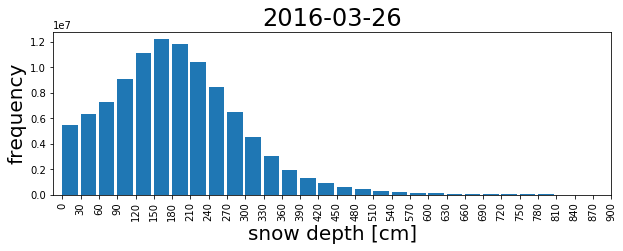

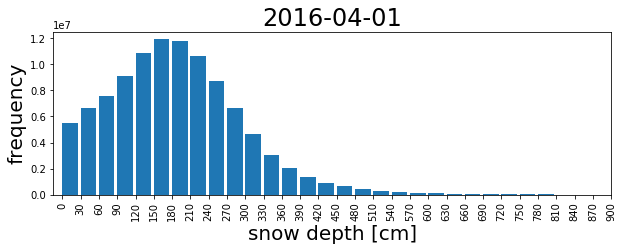

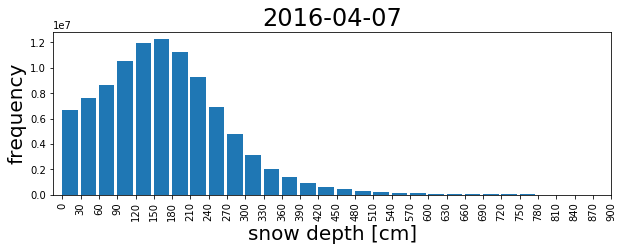

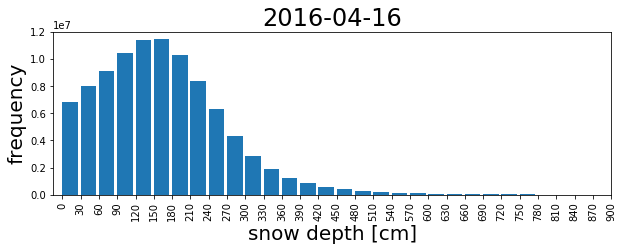

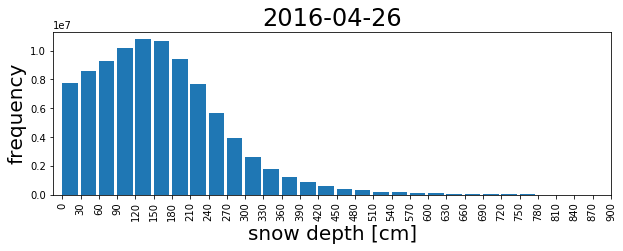

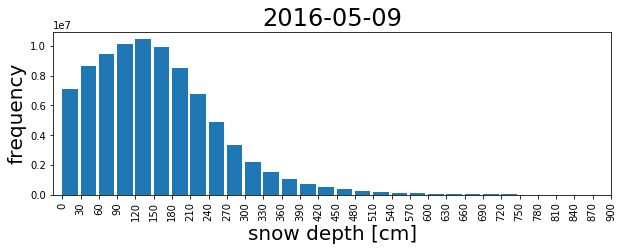

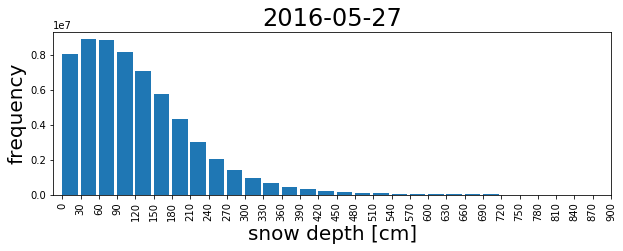

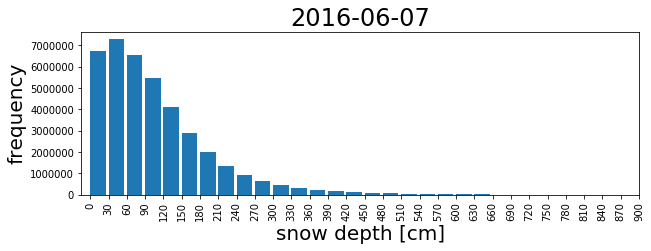

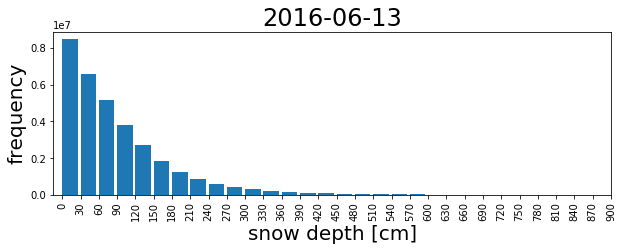

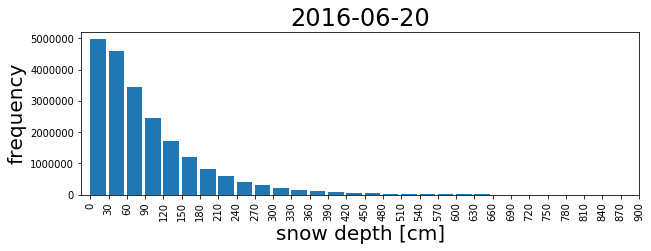

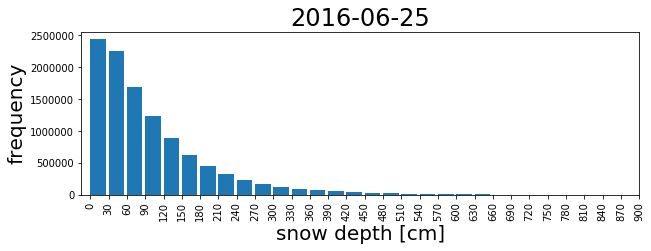

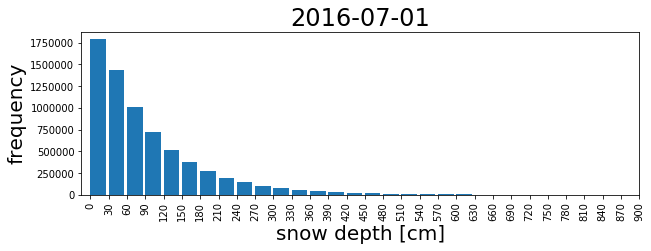

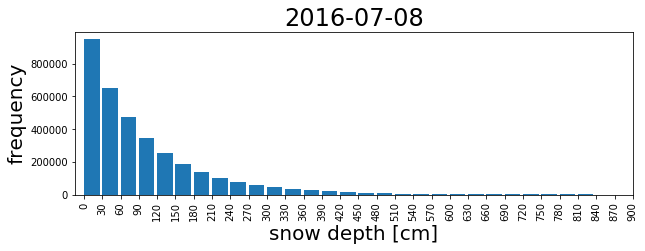

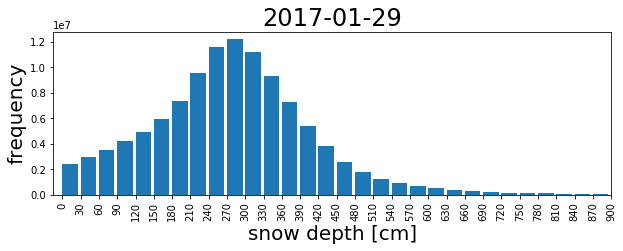

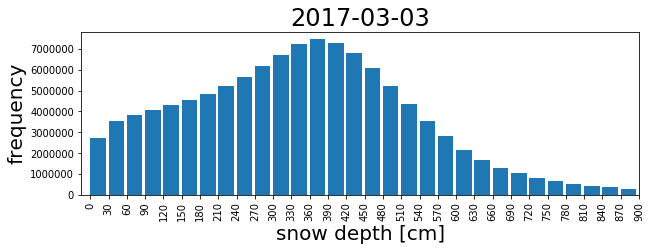

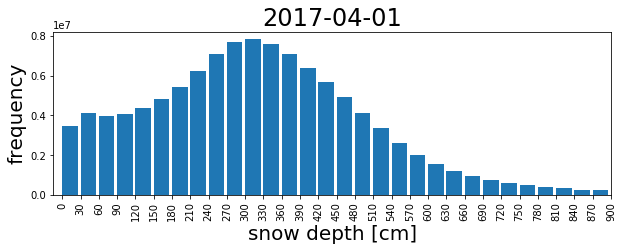

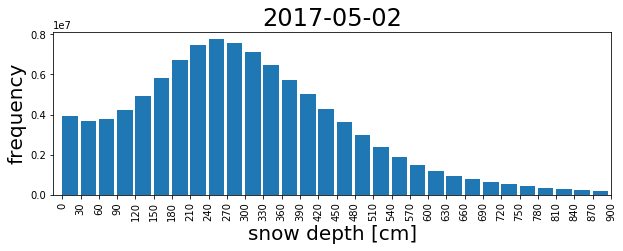

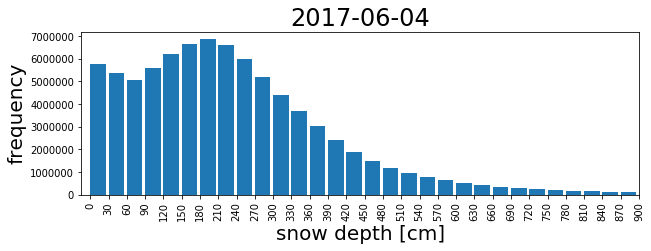

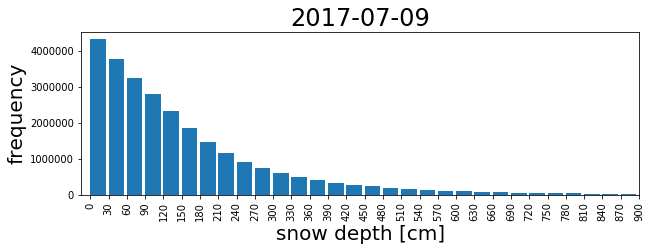

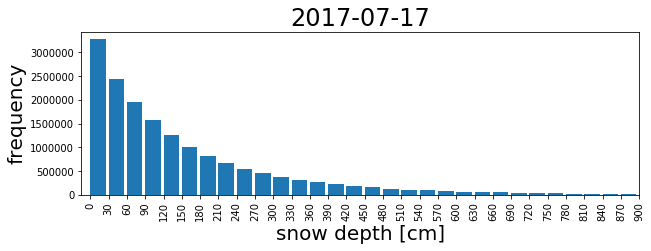

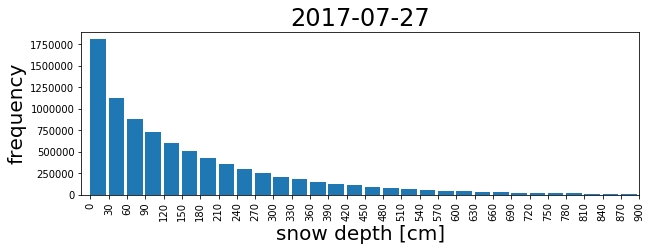

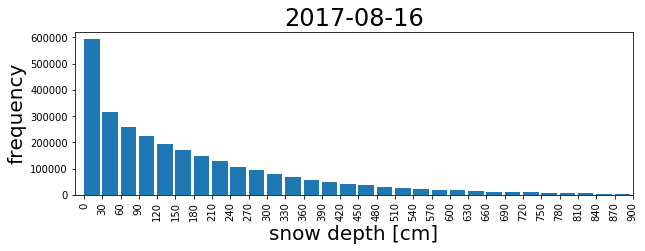

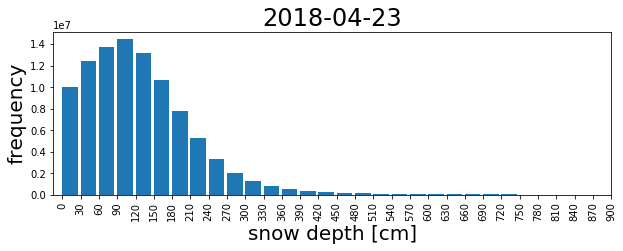

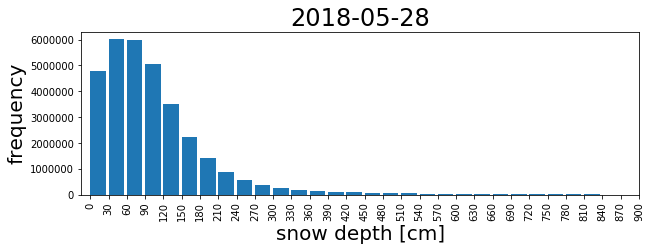

In [37]:
for column in df_h:
    plt.figure(figsize=(10,3))
    df_h[column][:-1].plot.bar(width=0.85, align='edge') #bar plot of each column (minus the last row)
    plt.title(str(column), fontsize=fs_titles)
    plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('frequency', fontsize=fs_axes)
    plt.xlim(-.5,34) #34 is # of bins to display -- 34x30cm = 1000+cm (i.e. 10m)